In [1]:
from selfregulation.utils.utils import get_info,  get_behav_data_master, get_admin_data, get_behav_data
from selfregulation.utils.data_preparation_utils import remove_correlated_task_variables, remove_outliers
from selfregulation.utils.r_to_py_utils import missForest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/usr/local/lib/python3.5/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
/usr/local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def plot_skewness(data_train, data_test_master, data_test_covid, title): 
    # Evaluating skew, plotting skewness for the variables included in the analysis
    fig, ax = plt.subplots(1, 3)
    fig.tight_layout() 
    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(top=0.80)

    ax[0].hist(data_train.skew(), bins=20, alpha=1, facecolor='green')
    ax[0].title.set_text('Training dataset')
    ax[0].set_xlabel("Skewness of variables")
    ax[0].set_ylabel("# Variables")

    ax[1].hist(data_test_master.skew(), bins=20, alpha=1, facecolor='gold')
    ax[1].title.set_text('Master dataset')
    ax[1].set_xlabel("Skewness of variables")
    ax[1].set_ylabel("# Variables")

    ax[2].hist(data_test_covid.skew(), bins=20, alpha=1, facecolor='darkblue')
    ax[2].title.set_text('Covid dataset')
    ax[2].set_xlabel("Skewness of variables")
    ax[2].set_ylabel("# Variables")
    
    plt.show

In [3]:
def transform_qt(data_train,
                 data_test = None,
                 threshold =1,
                 drop_failed = True,
                 verbose = True,
                 quantile = 100 ,
                 distribution = 'normal',
                 output_train= True):
    data = data_train.copy()
    #transformer
    qt = QuantileTransformer(n_quantiles=quantile, random_state=0, output_distribution = distribution)
    data_qt = pd.DataFrame(qt.fit_transform(data), columns = data.columns, index= data.index)
    print('*'*70)
    print('Training dataset')
    print('*'*70)

    #--------------------------------------------------------------
    good_vars= data_qt.loc[:,abs(data_qt.skew())<1]
    bad_vars = set(data_qt)-set(good_vars)
    print('* Number of variables still skewed:', len(bad_vars))
    #--------------------------------------------------------------
    
    # temporary removal of outliers remove outliers
    tmp = remove_outliers(data_qt)
    successful_transforms= data_qt.loc[:,abs(tmp.skew())<threshold]
    if verbose:
        print('* Successfully transformed %s variables after outlier removal' % len(successful_transforms.columns))
    dropped_vars = set(data_qt)-set(successful_transforms)
    if verbose:
        print('* %s variables could not be transformed successfully' % len(dropped_vars))
    if drop_failed:
        print('Check')
        data_qt.drop(dropped_vars, axis=1, inplace = True)
        if verbose:
            print('*Dropping %s skewed data that could not be transformed successfully:' % len(dropped_vars))
            print('\n'.join(dropped_vars))
            print('*' * 70)
    data_qt.columns = [i + '.qt' for i in data_qt]
    if data_test is not None:
       #transform datatrain using the calculation from the training dataset
        data_tst = data_test.copy()
        data_tst_qt = pd.DataFrame(qt.transform(data_tst), columns = data_tst.columns, index= data_tst.index)
        print('*'*70)
        print('Testing dataset')
        print('*'*70)

        #--------------------------------------------------------------
        good_vars2= data_tst_qt.loc[:,abs(data_tst_qt.skew())<1]
        bad_vars2 = set(data_tst_qt)-set(good_vars2)
        print('* Number of variables still skewed:', len(bad_vars2))
        #--------------------------------------------------------------
        
        # remove outliers
        tmp_tst = remove_outliers(data_tst_qt)
        successful_transforms_tst= data_tst_qt.loc[:,abs(tmp_tst.skew())<threshold]
        if verbose:
            print('* Successfully transformed %s variables after outlier removal' % len(successful_transforms_tst.columns))
        dropped_vars_tst = set(data_tst_qt)-set(successful_transforms_tst)
        if verbose:
            print('* %s variables could not be transformed successfully' % len(dropped_vars_tst))
        if drop_failed:
            data_tst_qt.drop(dropped_vars_tst, axis=1, inplace = True)
            if verbose:
                print('*Dropping %s skewed data that could not be transformed successfully:' % len(dropped_vars_tst))
                print('\n'.join(dropped_vars_tst))
                print('*'*70)
        data_tst_qt.columns = [i + '.qt' for i in data_tst_qt]
        if output_train == True:
            return data_qt.sort_index(axis = 1), data_tst_qt.sort_index(axis = 1), dropped_vars, dropped_vars_tst
        else:
            return data_tst_qt.sort_index(axis = 1), dropped_vars_tst
    else:
        return data_qt.sort_index(axis = 1), dropped_vars

In [4]:
def transform_pt(data_train,
                 data_test = None,
                 threshold =1,
                 drop_failed = True,
                 verbose = True,
                 output_train= True):
    data = data_train.copy()
    #transformer
    pt = PowerTransformer(method='yeo-johnson', standardize=True)
    data_pt = pd.DataFrame(pt.fit_transform(data), columns = data.columns, index= data.index)
    print('*'*70)
    print('Training dataset')
    print('*'*70)

    #--------------------------------------------------------------
    good_vars= data_pt.loc[:,abs(data_pt.skew())<1]
    bad_vars = set(data_pt)-set(good_vars)
    print('* Number of variables still skewed:', len(bad_vars))
    #--------------------------------------------------------------
    
    # temporary removal of outliers remove outliers
    tmp = remove_outliers(data_pt)
    
    successful_transforms= data_pt.loc[:,abs(tmp.skew())<threshold]
    if verbose:
        print('* Successfully transformed %s variables' % len(successful_transforms.columns))
    dropped_vars = set(data_pt)-set(successful_transforms)
    if verbose:
        print('* %s variables could not be transformed successfully' % len(dropped_vars))
    if drop_failed:
        data_pt.drop(dropped_vars, axis=1, inplace = True)
        if verbose:
            print('Dropping %s skewed data that could not be transformed successfully:' % len(dropped_vars))
            print('\n'.join(dropped_vars))
            print('*' * 70)
    data_pt.columns = [i + '.pt' for i in data_pt]
    if data_test is not None:
       #transform datatrain using the calculation from the training dataset
        data_tst = data_test.copy()
        data_tst_pt = pd.DataFrame(pt.transform(data_tst), columns = data_tst.columns, index= data_tst.index)
        print('*'*70)
        print('Testing dataset') 
        print('*'*70)
        #--------------------------------------------------------------
        good_vars2= data_tst_pt.loc[:,abs(data_tst_pt.skew())<1]
        bad_vars2 = set(data_tst_pt)-set(good_vars2)
        print('* Number of variables still skewed:', len(bad_vars2))
        #--------------------------------------------------------------

        # remove outliers
        tmp_tst = remove_outliers(data_tst_pt)
        successful_transforms_tst= data_tst_pt.loc[:,abs(tmp_tst.skew())<threshold]
        if verbose:
            print('* Successfully transformed %s variables' % len(successful_transforms_tst.columns))
        dropped_vars_tst = set(data_tst_pt)-set(successful_transforms_tst)
        if verbose:
            print('* %s variables could not be transformed successfully' % len(dropped_vars_tst))
        if drop_failed:
            data_tst_pt.drop(dropped_vars_tst, axis=1, inplace = True)
            if verbose:
                print('* Dropping %s skewed data that could not be transformed successfully:' % len(dropped_vars_tst))
                print('\n'.join(dropped_vars_tst))
                print('*'*70)
        data_tst_pt.columns = [i + '.pt' for i in data_tst_pt]
        if output_train == True:
            return data_pt.sort_index(axis = 1), data_tst_pt.sort_index(axis = 1), dropped_vars, dropped_vars_tst
        else:
            return data_tst_pt.sort_index(axis = 1),  dropped_vars_tst
    else:
        return data_pt.sort_index(axis = 1),dropped_vars

In [5]:
def select_data(orig_data_set_training, orig_data_set_testing): 
    X =  pd.concat([orig_data_set_training, orig_data_set_testing])
    y  = [0] * len(orig_data_set_training) + [1] * len(orig_data_set_testing)
    return(X, y)

In [6]:
def transform_qt_train_test_split(X, y): 
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    quantile_transformer = QuantileTransformer(random_state=0)
    X_train_trans = pd.DataFrame(quantile_transformer.fit_transform(X_train), columns = X_train.columns, index= X_train.index)
    X_test_trans = pd.DataFrame(quantile_transformer.fit_transform(X_test), columns = X_test.columns, index= X_test.index)
    
    return X_train, X_test, X_train_trans, X_test_trans

In [7]:
def plot_skeweness_2(X_train_trans, X_test_trans, title, color = 'color'): 
    # Evaluating skew, plotting skewness for the variables included in the analysis
    fig, ax = plt.subplots(1, 2)
    fig.tight_layout() 
    fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(top=0.80)

    ax[0].hist(X_train_trans.skew(), bins=20, alpha=1, facecolor='green')
    ax[0].title.set_text('Training dataset')
    ax[0].set_xlabel("Skewness of variables")
    ax[0].set_ylabel("# Variables")

    ax[1].hist(X_test_trans.skew(), bins=20, alpha=1, facecolor= color)
    ax[1].title.set_text('Testing dataset')
    ax[1].set_xlabel("Skewness of variables")
    ax[1].set_ylabel("# Variables")

    plt.show

In [8]:
def return_original_datasets_trans(X_train_trans, X_test_trans): 
    all_data = pd.concat([X_train_trans, X_test_trans ])
    orig_train_trans  = all_data[all_data.index.str.contains('train')]
    orig_test_trans  = all_data[all_data.index.str.contains('test')]
    return orig_train_trans, orig_test_trans

In [9]:
#remove df suffix 
def remove_suffix(df, suffix):
    df.columns = ['.'.join(i.split('.')[:-1]) if suffix in i else i for i in df.columns]

In [10]:
def get_failed_transforms_qt_pt(raw, trans_qt, trans_pt):
    successful_transforms_qt= trans_qt.loc[:,abs(trans_qt.skew())<1]
    successful_transforms_pt= trans_pt.loc[:,abs(trans_pt.skew())<1]
    
    bad_vars_qt = set(trans_qt)-set(successful_transforms_qt)
    bad_vars_pt = set(trans_pt)-set(successful_transforms_pt)
    bad_vars=set(list(bad_vars_qt) + list(bad_vars_pt))
    return bad_vars_qt, bad_vars_pt, bad_vars
 
def drop_failed_transforms_qt_pt(raw, trans_qt, trans_pt, bad_vars):
    raw_bad      = raw.loc[:,bad_vars]
    trans_qt_bad = trans_qt.loc[:,bad_vars]
    trans_pt_bad = trans_pt.loc[:,bad_vars]
    return raw_bad.sort_index(axis=1), trans_qt_bad.sort_index(axis=1),trans_pt_bad.sort_index(axis=1) 

def get_final_melted_qt_pt(raw_bad, trans_qt_bad, trans_pt_bad ):
    
    raw_melted  = raw_bad.melt().assign(stage='raw')
    trans_qt_melted= trans_qt_bad.melt().assign(stage='transformed_qt')
    trans_pt_melted= trans_pt_bad.melt().assign(stage='transformed_pt')
    final = pd.concat([raw_melted, trans_qt_melted, trans_pt_melted])
    # remove missing values
    final = final.replace([np.inf, -np.inf], np.nan)
    final.dropna(inplace=True)
    return final

def plot_individual_distribution(raw, final, bad_vars_qt, bad_vars_pt): 
    n_rows=raw.shape[1]
    f, axes = plt.subplots(n_rows, 3, figsize=(7, n_rows*3))
    for row, name in enumerate(sorted(final.variable.unique())):
        for col, stage in enumerate(['raw','transformed_qt', 'transformed_pt']):
            subset = final.query('variable == "%s" and stage == "%s"' % (name, stage))
            if len(subset) > 0:
                
                if col == 0: 
                    axes[row][col].hist(subset['value'], bins=20, color='steelblue', alpha =0.5)
                elif col ==1 and name in bad_vars_qt: 
                    axes[row][col].hist(subset['value'], bins=20, color ='red')      
                elif col ==2 and name in bad_vars_pt: 
                    axes[row][col].hist(subset['value'], bins=20, color ='red')
                else: 
                    axes[row][col].hist(subset['value'], bins=20, color='steelblue', alpha =0.5)

                axes[row][0].set_ylabel(('\n').join(name.split('.')), fontsize=15,
                                   rotation=0, labelpad=100)
                axes[row][col].set_title(str(stage))
    return plt.subplots_adjust(hspace=.4)


## Get full dataset of selected variables and split into training and test dataset

In [11]:
data_dir    = get_info('data_directory')
selected_var_covid  = get_behav_data(verbose=True)
selected_var_master = get_behav_data_master(dataset = 'Complete_02-16-2019', file = 'meaningful_variables.csv', verbose=True)

Getting dataset: /SRO/Data/Complete_Covid_11-12-2020...:
file: meaningful_variables.csv 
 
Getting dataset: /SRO/Data_master/Complete_02-16-2019...:
file: meaningful_variables.csv 
 


In [12]:
#Some variables from Ian have different names, as different layout of survey was used, rename
#1.holt_laury_survey                             holt_laury_survey_correctlayout
#2.selection_optimization_compensation_survey    selection_optimization_compensation_survey_correctlayout
#3.sensation_seeking_survey                      sensation_seeking_survey_correctlayout
selected_var_master.columns = [i.replace('holt_laury_survey', 'holt_laury_survey_correctlayout') for i in selected_var_master]
selected_var_master.columns = [i.replace('selection_optimization_compensation_survey', 'selection_optimization_compensation_survey_correctlayout') for i in selected_var_master]
selected_var_master.columns = [i.replace('sensation_seeking_survey', 'sensation_seeking_survey_correctlayout') for i in selected_var_master]

**Split the master dataset to have subjects whose data were collected and analyzed only at T1 (master, N = 386 ) and those whose data were collected and analyzed both at T1 (master) and T2 (covid) (N = 107)**

In [13]:
dict_train_master   = get_admin_data(data_dir, 'unique_turkers_master.json')
dict_test_master  = get_admin_data(data_dir, 'overlap_turkers.json')

In [14]:
train_master = list(dict_train_master.keys()) 
test_master = list(dict_test_master.keys()) 

In [15]:
train_master.sort()
test_master.sort()

In [16]:
selected_var_master_train  = selected_var_master.loc[train_master ,:]
selected_var_master_test = selected_var_master.loc[test_master ,:]

print("Number of subject for master training, those tested only once by Ian:", len(selected_var_master_train.index))
print("Number of subject for master testing:", len(selected_var_master_test.index))


Number of subject for master training, those tested only once by Ian: 386
Number of subject for master testing: 107


In [17]:
assert len(selected_var_master_train)== len(train_master), 'data has wrong number of subjects'
assert train_master == list(selected_var_master_train.index),'data has wrong id subjects'

In [18]:
assert len(selected_var_master_test)== len(test_master), 'data has wrong number of subjects'
assert test_master == list(selected_var_master_test.index),'data has wrong id subjects'

# Data cleaning - procedure A using Quantile Transform (QT)

Because many of our analyses assume normally distributed variables, we transformed all variables using an empirical normal quantile transformation. In order to do so we first computed the quantiles used for transforming on the training training dataset of 386 subjects who were only tested in 2016 only. Then, we fit the transformation on the 107 subjects who were tested twice. The fit was applied separately for the data collected in 2016 and those collected during covid. We then removed data that were more than 2.5 times the interquartile range above the third quartile or below the first quartile. Any variable that remained excessively skewed after transformation and outlier removal was dropped. 

**The QT transformation is not per se sufficient to have variables whose skewness is within the absolute threshold of 1. In order to do so, it is necessary to remove the outliers**

## Transform variables 

In [19]:
master_train_trans_qt, master_test_trans_qt, master_train_drop_qt, master_test_drop_qt = transform_qt(
             data_train  = selected_var_master_train,
             data_test   = selected_var_master_test, output_train = True, drop_failed=False)

**********************************************************************
Training dataset
**********************************************************************
* Number of variables still skewed: 43
* Successfully transformed 204 variables after outlier removal
* 0 variables could not be transformed successfully
**********************************************************************
Testing dataset
**********************************************************************
* Number of variables still skewed: 73
* Successfully transformed 203 variables after outlier removal
* 1 variables could not be transformed successfully


In [20]:
covid_test_trans_qt, covid_test_drop_qt  = transform_qt(
             data_train = selected_var_master_train, 
             data_test  = selected_var_covid, output_train= False, drop_failed=False)

**********************************************************************
Training dataset
**********************************************************************
* Number of variables still skewed: 43
* Successfully transformed 204 variables after outlier removal
* 0 variables could not be transformed successfully
**********************************************************************
Testing dataset
**********************************************************************
* Number of variables still skewed: 58
* Successfully transformed 204 variables after outlier removal
* 0 variables could not be transformed successfully


The distributions show that several variables in the test datasets retain a skewness above 1 after QT transform


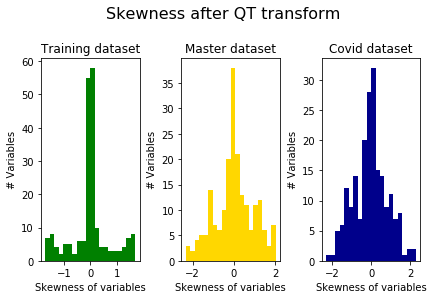

In [21]:
plot_skewness(master_train_trans_qt, master_test_trans_qt, covid_test_trans_qt, 'Skewness after QT transform')
print('The distributions show that several variables in the test datasets retain a skewness above 1 after QT transform')

In [22]:
#Drop variables that can't rescue transformation after remoal of outliers this is usally done by transform variable
print('** Drop variables that are not rescued by outlier removal**')
master_train_drop_qt= [sub + '.qt' for sub in master_train_drop_qt] ; print('Master train dataset:', master_train_drop_qt);
master_test_drop_qt = [sub + '.qt' for sub in master_test_drop_qt] ; print('Master test dataset:', master_test_drop_qt);
covid_test_drop_qt  = [sub + '.qt' for sub in covid_test_drop_qt] ; print('Covid dataset:',covid_test_drop_qt);


data_master_train_qt = master_train_trans_qt.copy()
data_master_test_qt  = master_test_trans_qt.copy()
data_covid_test_qt   = covid_test_trans_qt.copy()


data_master_train_qt.drop(master_train_drop_qt, axis=1, inplace = True)
data_master_test_qt.drop(master_test_drop_qt, axis=1, inplace = True)
data_covid_test_qt.drop(covid_test_drop_qt, axis=1, inplace = True)

** Drop variables that are not rescued by outlier removal**
Master train dataset: []
Master test dataset: ['ten_item_personality_survey.extraversion.qt']
Covid dataset: []


## Remove outliers

In [23]:
training_clean_qt        = remove_outliers(data_master_train_qt)
master_clean_qt          = remove_outliers(data_master_test_qt)
covid_clean_qt           = remove_outliers(data_covid_test_qt)

After outliers removal, the variables have a skeweness within the desired threshold
Bear in mind: one variable needs to be dropped from the master dataset as skeweness remains above 1 even after removal of the outliers


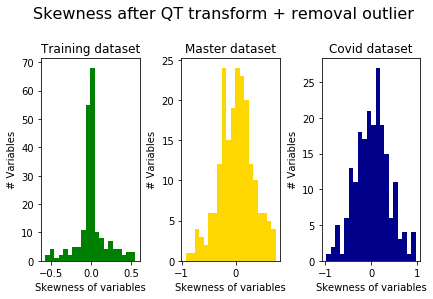

In [24]:
plot_skewness(training_clean_qt, master_clean_qt,covid_clean_qt, 'Skewness after QT transform + removal outlier')
print('After outliers removal, the variables have a skeweness within the desired threshold')
print('Bear in mind: one variable needs to be dropped from the master dataset as skeweness remains above 1 even after removal of the outliers')

In [25]:
print('Mean skewness training:,', np.mean(training_clean_qt.skew()))
print('Median skewness training:,', np.median(training_clean_qt.skew()))

Mean skewness training:, 0.0005689025318003093
Median skewness training:, -0.006706848917638868


In [26]:
print('Mean skewness master testing dataset :,', np.mean(master_clean_qt.skew()))
print('Median skewness master testing dataset:,', np.median(master_clean_qt.skew()))

Mean skewness master testing dataset :, 0.001196723612437766
Median skewness master testing dataset:, 0.01009642277615274


In [27]:
print('Mean skewness covid testing dataset :,', np.mean(covid_clean_qt.skew()))
print('Median skewness covid testing dataset:,', np.median(covid_clean_qt.skew()))

Mean skewness covid testing dataset :, 0.026775321647489924
Median skewness covid testing dataset:, 0.047787230058859015


# Data cleaning - procedure A using Power Transformer (PT)


In [28]:
master_train_trans_pt, master_test_trans_pt, master_train_drop_pt, master_test_drop_pt = transform_pt(
             data_train  = selected_var_master_train,
             data_test   = selected_var_master_test, output_train = True, drop_failed=False)

**********************************************************************
Training dataset
**********************************************************************
* Number of variables still skewed: 4
* Successfully transformed 201 variables
* 3 variables could not be transformed successfully
**********************************************************************
Testing dataset
**********************************************************************
* Number of variables still skewed: 10
* Successfully transformed 200 variables
* 4 variables could not be transformed successfully


In [29]:
covid_test_trans_pt,covid_test_drop_pt = transform_pt(
             data_train = selected_var_master_train, 
             data_test  = selected_var_covid, output_train= False, drop_failed=False)

**********************************************************************
Training dataset
**********************************************************************
* Number of variables still skewed: 4
* Successfully transformed 201 variables
* 3 variables could not be transformed successfully
**********************************************************************
Testing dataset
**********************************************************************
* Number of variables still skewed: 13
* Successfully transformed 196 variables
* 8 variables could not be transformed successfully


The distributions show that several variables in the test datasets retain a skewness above 1 after PT transform


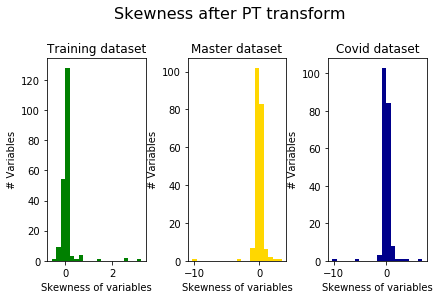

In [30]:
plot_skewness(master_train_trans_pt, master_test_trans_pt, covid_test_trans_pt, 'Skewness after PT transform')
print('The distributions show that several variables in the test datasets retain a skewness above 1 after PT transform')

In [31]:
#Drop variables that can't rescue transformation after remoal of outliers this is usally done by transform variable
print('** Drop variables that are not rescued by outlier removal**')
master_train_drop_pt= [sub + '.pt' for sub in master_train_drop_pt] ; print('Master train dataset:', master_train_drop_pt);
master_test_drop_pt = [sub + '.pt' for sub in master_test_drop_pt] ; print('Master test dataset:', master_test_drop_pt);
covid_test_drop_pt  = [sub + '.pt' for sub in covid_test_drop_pt] ; print('Covid dataset:',covid_test_drop_pt);


data_master_train_pt = master_train_trans_pt.copy()
data_master_test_pt  = master_test_trans_pt.copy()
data_covid_test_pt   = covid_test_trans_pt.copy()

data_master_train_pt.drop(master_train_drop_pt, axis=1, inplace = True)
data_master_test_pt.drop(master_test_drop_pt, axis=1, inplace = True)
data_covid_test_pt.drop(covid_test_drop_pt, axis=1, inplace = True)


** Drop variables that are not rescued by outlier removal**
Master train dataset: ['bickel_titrator.hyp_discount_rate_small.pt', 'bickel_titrator.hyp_discount_rate_large.pt', 'bickel_titrator.hyp_discount_rate_medium.pt']
Master test dataset: ['bickel_titrator.hyp_discount_rate_small.pt', 'bickel_titrator.hyp_discount_rate_medium.pt', 'bickel_titrator.hyp_discount_rate_large.pt', 'kirby.hyp_discount_rate_large.pt']
Covid dataset: ['bickel_titrator.hyp_discount_rate_large.pt', 'upps_impulsivity_survey.positive_urgency.pt', 'dickman_survey.dysfunctional.pt', 'bickel_titrator.hyp_discount_rate_medium.pt', 'kirby.hyp_discount_rate_medium.pt', 'bickel_titrator.hyp_discount_rate_small.pt', 'kirby.hyp_discount_rate_small.pt', 'kirby.hyp_discount_rate_large.pt']


## Remove outliers

In [32]:
training_clean_pt        = remove_outliers(data_master_train_pt)
master_clean_pt          = remove_outliers(data_master_test_pt)
covid_clean_pt           = remove_outliers(data_covid_test_pt)

After outliers removal, the variables have a skeweness within the desired threshold
Bear in mind: some variables needed to be dropped as skeweness remains above 1 even after removal of the outliers


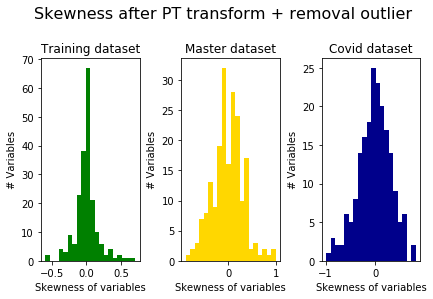

In [33]:
plot_skewness(training_clean_pt, master_clean_pt,covid_clean_pt, 'Skewness after PT transform + removal outlier')
print('After outliers removal, the variables have a skeweness within the desired threshold')
print('Bear in mind: some variables needed to be dropped as skeweness remains above 1 even after removal of the outliers')


In [34]:
print('Mean skewness training:,', np.mean(training_clean_pt.skew()))
print('Median skewness training:,', np.median(training_clean_pt.skew()))

Mean skewness training:, -0.0020319587796381053
Median skewness training:, -0.0018688868080818574


In [35]:
print('Mean skewness master testing dataset :,', np.mean(master_clean_pt.skew()))
print('Median skewness master testing dataset:,', np.median(master_clean_pt.skew()))

Mean skewness master testing dataset :, -0.01204820366458741
Median skewness master testing dataset:, -0.011335564051186974


In [36]:
print('Mean skewness covid testing dataset :,', np.mean(covid_clean_pt.skew()))
print('Median skewness covid testing dataset:,', np.median(covid_clean_pt.skew()))

Mean skewness covid testing dataset :, -0.011939157164659665
Median skewness covid testing dataset:, 0.0006450153723006828


# Look at problematic variables immediately after transform and before outlier removal

## Master

Plot raw, QT and PT transformed problematic variables for the master test dataset.
Where the distribution is red, it means that the transform was not successful.
Most of the variables are rescued by outlier removal
All problemtic variables across QT and PT transforms are plotted


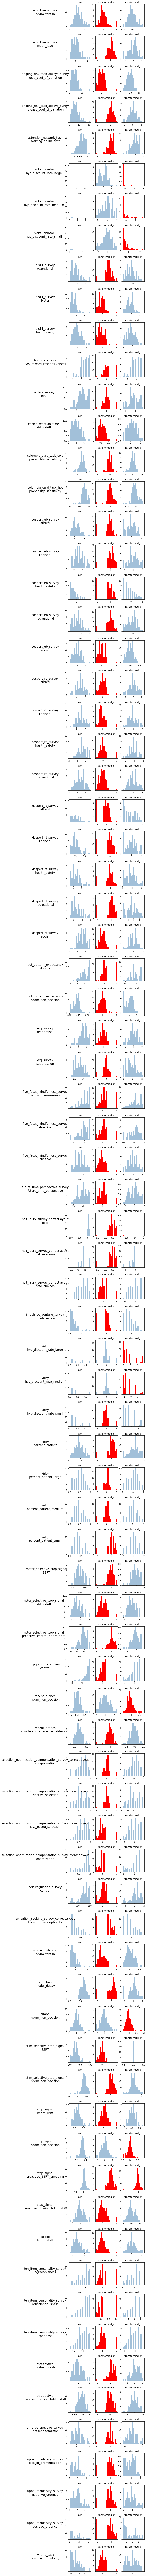

In [37]:
remove_suffix(master_test_trans_qt, 'qt')
remove_suffix(master_test_trans_pt, 'pt')
master_bad_vars_qt, master_bad_vars_pt, master_bad_vars = get_failed_transforms_qt_pt(selected_var_master_test, 
                                                                 master_test_trans_qt, 
                                                                 master_test_trans_pt)

master_raw_bad, master_trans_qt_bad, master_trans_pt_bad = drop_failed_transforms_qt_pt(selected_var_master_test, 
                                                                   master_test_trans_qt, 
                                                                   master_test_trans_pt, 
                                                                   master_bad_vars)

master_final = get_final_melted_qt_pt(master_raw_bad, 
                               master_trans_qt_bad,
                               master_trans_pt_bad)

plot_individual_distribution(master_raw_bad, master_final, master_bad_vars_qt, master_bad_vars_pt)
print('Plot raw, QT and PT transformed problematic variables for the master test dataset.')
print('Where the distribution is red, it means that the transform was not successful.')
print('Most of the variables are rescued by outlier removal')
print('All problemtic variables across QT and PT transforms are plotted')

## Covid

Plot raw, QT and PT transformed problematic variables for the COVID test dataset.
Where the distribution is red, it means that the transform was not successful.
Most of the variables are rescued by outlier removal
All problemtic variables across QT and PT transforms are plotted


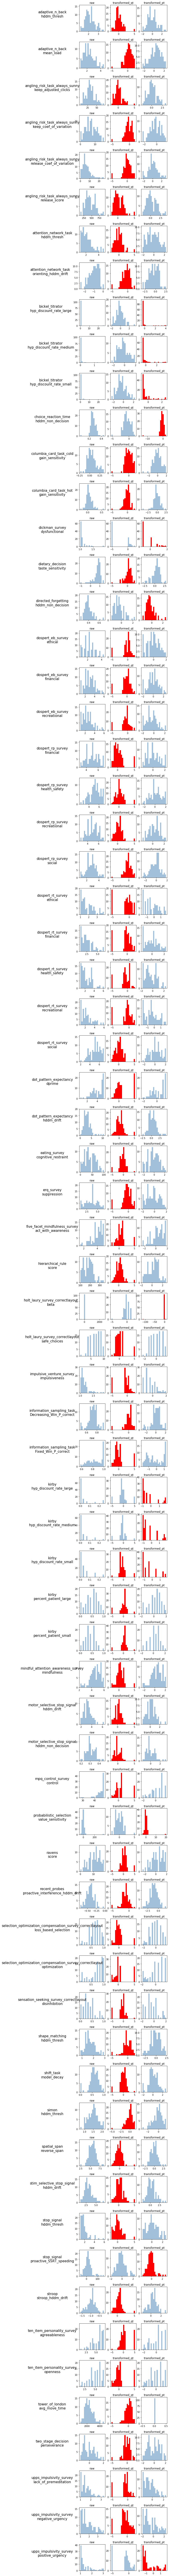

In [38]:
remove_suffix(covid_test_trans_qt, 'qt')
remove_suffix(covid_test_trans_pt, 'pt')
covid_bad_vars_qt, covid_bad_vars_pt, covid_bad_vars = get_failed_transforms_qt_pt(selected_var_covid, 
                                                                 covid_test_trans_qt, 
                                                                 covid_test_trans_pt)

covid_raw_bad, covid_trans_qt_bad, covid_trans_pt_bad = drop_failed_transforms_qt_pt(selected_var_covid, 
                                                                   covid_test_trans_qt, 
                                                                   covid_test_trans_pt, 
                                                                   covid_bad_vars)

covid_final = get_final_melted_qt_pt(covid_raw_bad, 
                               covid_trans_qt_bad,
                               covid_trans_pt_bad)

plot_individual_distribution(covid_raw_bad, covid_final, covid_bad_vars_qt, covid_bad_vars_pt)
print('Plot raw, QT and PT transformed problematic variables for the COVID test dataset.')
print('Where the distribution is red, it means that the transform was not successful.')
print('Most of the variables are rescued by outlier removal')
print('All problemtic variables across QT and PT transforms are plotted')

# Data cleaning- procedure B using train_test_split from sklearn
***********************************************************************************************
****************** <font color='red'>INVALID APPROACH DON'T RUN</font>************************
*********************************************************************************************** 

Here the train and test dataset are defined using the train_test_split that splits the overall dataset (testing + train) into random train and test subset. 

By then obtaining the original training (data collected by Ian only) and the testsdatasets (data collected by Ian, and data collected on the same subjects in 2020) the variables have a skewness within the desired threshold and it is not needed to remove outliers.



In [ ]:
#Add suffixes as there might be two subjects with same label
training       = selected_var_master_train.rename(index=lambda s: s + '_train')
master         =  selected_var_master_test.rename(index=lambda s: s + '_test')
covid          = selected_var_covid.rename(index=lambda s: s + '_test')


## Training dataset and master testing assessment 

In [ ]:
X,y = select_data(training, master)
assert len(X) == 493, 'WRONG NUMBER OF SUBJECTS'
assert len(X.columns) == 204, 'WRONG NUMBER OF VARIABLES'

X_train, X_test, X_train_trans, X_test_trans = transform_qt_train_test_split(X, y)
plot_skeweness_2(X_train_trans, X_test_trans, color = 'gold',  title ='Skewness of variables for the random train/test split')

orig_train_trans, orig_master_trans = return_original_datasets_trans(X_train_trans, X_test_trans)
assert len(orig_train_trans) == len(training), 'WRONG NUMBER OF SUBJECTS'
assert len(orig_master_trans) == len(master), 'WRONG NUMBER OF VARIABLES'
plot_skeweness_2(orig_train_trans, orig_master_trans, color = 'gold', title ='Skewness of variables for the original train/test data')

successful_transforms_train= orig_train_trans.loc[:,abs(orig_train_trans.skew())<1]
dropped_vars_train = set(orig_train_trans)-set(successful_transforms_train)

print('** Successfully transformed %s variables for training dataset' % len(successful_transforms_train.columns))
print('** %s variables could not be transformed successfully' % len(dropped_vars_train))

successful_transforms_master= orig_master_trans.loc[:,abs(orig_master_trans.skew())<1]
dropped_vars_master = set(orig_master_trans)-set(successful_transforms_master)
print('** Successfully transformed %s variables for testing dataset' % len(successful_transforms_master.columns))
print('** %s variables could not be transformed successfully' % len(dropped_vars_master))

## Training dataset and covid testing assessment

In [ ]:
X,y = select_data(training, covid)
assert len(X) == 493, 'WRONG NUMBER OF SUBJECTS'
assert len(X.columns) == 204, 'WRONG NUMBER OF VARIABLES'

X_train, X_test, X_train_trans, X_test_trans = transform_qt_train_test_split(X, y)
plot_skeweness_2(X_train_trans, X_test_trans, color = 'blue',  title ='Skewness of variables for the random train/test split')

orig_train_trans, orig_covid_trans = return_original_datasets_trans(X_train_trans, X_test_trans)
assert len(orig_train_trans) == len(training_clean), 'WRONG NUMBER OF SUBJECTS'
assert len(orig_covid_trans) == len(covid_clean), 'WRONG NUMBER OF VARIABLES'
plot_skeweness_2(orig_train_trans, orig_covid_trans, color = 'blue', title ='Skewness of variables for the original train/test data')

successful_transforms_train= orig_train_trans.loc[:,abs(orig_train_trans.skew())<1]
dropped_vars_train = set(orig_train_trans)-set(successful_transforms_train)

print('** Successfully transformed %s variables for training dataset' % len(successful_transforms_train.columns))
print('** %s variables could not be transformed successfully' % len(dropped_vars_train))

successful_transforms_covid= orig_covid_trans.loc[:,abs(orig_covid_trans.skew())<1]
dropped_vars_covid = set(orig_covid_trans)-set(successful_transforms_covid)
print('** Successfully transformed %s variables for testing dataset' % len(successful_transforms_covid.columns))
print('** %s variables could not be transformed successfully' % len(dropped_vars_covid))